# Import Libraries

In [1]:
import cv2
import numpy as np
from collections import deque
import random
!pip install webcolors
import webcolors
import matplotlib.pyplot as plt
import time
import heapq

In [2]:
# Function to convert a hexadecimal color code to its corresponding color name
def hex_to_color_name(hex_code):
    try:
        color_name = webcolors.hex_to_name(hex_code)
        return color_name
    except ValueError:
        # If the hexadecimal code is not found in the color database, return "Unknown"
        return "Unknown"

# DFS Algorithm

In [3]:
# Color detection using DFS
def color_detection_dfs(image, target_color, tolerance=50):
    height, width, _ = image.shape
    target_color = np.array(target_color)

    # Create a stack for DFS
    stack = []

    # Initialize a mask to keep track of visited pixels
    visited = np.zeros((height, width), dtype=bool)

    # Find the starting pixel for DFS (closest to target_color)
    min_distance = float('inf')
    start_pixel = None

    for y in range(height):
        for x in range(width):
            current_color = np.array(image[y, x])
            distance = np.linalg.norm(current_color - target_color)

            if distance < min_distance:
                min_distance = distance
                start_pixel = (y, x)

    if start_pixel is None:
        return image

    # Define 4-connected neighbors
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    # Perform DFS
    stack.append(start_pixel)

    while stack:
        current_y, current_x = stack.pop()
        current_color = np.array(image[current_y, current_x])

        # Check if the current pixel is within the tolerance range
        if np.linalg.norm(current_color - target_color) <= tolerance:
            image[current_y, current_x] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

        # Visit neighbors
        for dy, dx in neighbors:
            y, x = current_y + dy, current_x + dx

            if 0 <= y < height and 0 <= x < width and not visited[y, x]:
                stack.append((y, x))
                visited[y, x] = True

    return image

def closest_color_DFS(requested_color):
    min_colors = {}
    requested_color_hex = '#{:02x}{:02x}{:02x}'.format(*requested_color)
    for key, name in webcolors.CSS3_NAMES_TO_HEX.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(name)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

# BFS Algorithm

In [4]:
# Color detection using BFS
def color_detection_bfs(image, target_color, tolerance=50):
    height, width, _ = image.shape
    target_color = np.array(target_color)

    # Create a queue for BFS
    queue = deque()

    # Initialize a mask to keep track of visited pixels
    visited = np.zeros((height, width), dtype=bool)

    # Find the starting pixel for BFS (closest to target_color)
    min_distance = float('inf')
    start_pixel = None

    for y in range(height):
        for x in range(width):
            current_color = np.array(image[y, x])
            distance = np.linalg.norm(current_color - target_color)

            if distance < min_distance:
                min_distance = distance
                start_pixel = (y, x)

    if start_pixel is None:
        return image

    # Define 4-connected neighbors
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    # Perform BFS
    queue.append(start_pixel)
    visited[start_pixel[0], start_pixel[1]] = True

    while queue:
        current_y, current_x = queue.popleft()
        current_color = np.array(image[current_y, current_x])

        # Check if the current pixel is within the tolerance range
        if np.linalg.norm(current_color - target_color) <= tolerance:
            image[current_y, current_x] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

        # Visit neighbors
        for dy, dx in neighbors:
            y, x = current_y + dy, current_x + dx

            if 0 <= y < height and 0 <= x < width and not visited[y, x]:
                queue.append((y, x))
                visited[y, x] = True

    return image

def closest_color_BFS(requested_color):
    min_colors = {}
    requested_color_hex = '#{:02x}{:02x}{:02x}'.format(*requested_color)
    for key, name in webcolors.CSS3_NAMES_TO_HEX.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(name)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

# A* Algorithm

In [5]:
# Heuristic function (Manhattan distance in RGB space)
def heuristic(a, b):
    return np.sum(np.abs(a - b))

# A* algorithm
def astar_search(image, start, goal):
    height, width = image.shape
    open_list = []
    closed_list = set()

    heapq.heappush(open_list, (0, start))
    while open_list:
        current_cost, current_node = heapq.heappop(open_list)

        if current_node == goal:
            return current_cost, goal

        closed_list.add(current_node)

        neighbors = [
            (current_node[0] + 1, current_node[1]),
            (current_node[0] - 1, current_node[1]),
            (current_node[0], current_node[1] + 1),
            (current_node[0], current_node[1] - 1)
        ]

        for neighbor in neighbors:
            y, x = neighbor
            if 0 <= y < height and 0 <= x < width and neighbor not in closed_list:
                neighbor_cost = heuristic(image[y, x], image[goal])
                heapq.heappush(open_list, (current_cost + neighbor_cost, neighbor))

    return None


# Color detection using A*
def color_detection_astar(image, target_color, tolerance=50):
    height, width = image.shape
    target_color = np.array(target_color)

    # Convert the image to a 2D grid representation
    grid = np.zeros((height, width), dtype=object)
    for y in range(height):
        for x in range(width):
            grid[y, x] = tuple(image[y, x])

    # Initialize a dictionary to store color regions
    regions = {}

    # Detect color regions using A* search
    while True:
        # Find the pixel with the closest color to the target_color
        min_distance = float('inf')
        best_pixel = None

        for y in range(height):
            for x in range(width):
                current_color = np.array(grid[y, x])
                distance = heuristic(current_color, target_color)

                if distance < min_distance:
                    min_distance = distance
                    best_pixel = (y, x)

        # If no more color regions are found, exit the loop
        if min_distance > tolerance:
            break

        # Perform A* search to find a path with similar colors
        if best_pixel:
            goal_pixel = astar_search(grid, best_pixel, best_pixel)
            if goal_pixel:
                # Mark the detected color region with a unique color
                region_color = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]
                regions[region_color] = [(best_pixel[0], best_pixel[1])]
                if goal_pixel != best_pixel:
                    y, x = goal_pixel
                    regions[region_color].append((y, x))
                    grid[y, x] = tuple(region_color)

    # Mark the detected color regions in the original image
    for color, region in regions.items():
        for y, x in region:
            image[y, x] = color

    return image

def closest_color_Astar(requested_color):
    min_colors = {}
    requested_color_hex = '#{:02x}{:02x}{:02x}'.format(*requested_color)
    for key, name in webcolors.CSS3_NAMES_TO_HEX.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(name)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

# Colour Detection of RGB Values

In [6]:
# Function to get RGB values of detected color regions
def get_detected_colors_DFS(image, target_color, detection_func):
    result_image = closest_color_DFS(image.copy(), target_color)
    height, width, _ = image.shape
    colors = []
    for y in range(height):
        for x in range(width):
            color = result_image[y, x]
            colors.append(color)
    return colors

# Function to get RGB values of detected color regions
def get_detected_colors_BFS(image, target_color, detection_func):
    result_image =  closest_color_BFS(image.copy(), target_color)
    height, width, _ = image.shape
    colors = []
    for y in range(height):
        for x in range(width):
            color = result_image[y, x]
            colors.append(color)
    return colors

# Function to get RGB values of detected color regions
def get_detected_colors_Astar(image, target_color, detection_func):
    result_image = closest_color_Astar(image.copy(), target_color)
    height, width, _ = image.shape
    colors = []
    for y in range(height):
        for x in range(width):
            color = result_image[y, x]
            colors.append(color)
    return colors

# Colour Selection

In [7]:
# Load the image
image_path = "Chair Car Edward Hopper.jpg"
image = cv2.imread(image_path)

In [8]:
# Display the image for color selection
selected_color = None

def on_mouse_click(event, x, y, flags, param):
    global selected_color
    if event == cv2.EVENT_LBUTTONDOWN:
        selected_color = image[y, x]

In [9]:
# Create a window to display the image
cv2.namedWindow("Select Color")
cv2.setMouseCallback("Select Color", on_mouse_click)

# RGB Values

In [10]:
# Show the image and wait for the user to click
while True:
    cv2.imshow("Select Color", image)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('q') or selected_color is not None:
        break

cv2.destroyWindow("Select Color")

print("\n")

if selected_color is None:
    print("No color selected.")
else:
    print("Selected color (RGB):", selected_color)

print("\n")



Selected color (RGB): [ 88 158 121]




In [11]:
# Get the detected colors using each algorithm
dfs_detected_colors = (image, selected_color, get_detected_colors_DFS)
bfs_detected_colors = (image, selected_color, get_detected_colors_BFS)
astar_detected_colors = (image, selected_color, get_detected_colors_Astar)

In [12]:
# Convert the RGB values to NumPy arrays for each color channel
dfs_detected_colors = np.array(dfs_detected_colors)
bfs_detected_colors = np.array(bfs_detected_colors)
astar_detected_colors = np.array(astar_detected_colors)

C:\Users\User\AppData\Local\Temp\ipykernel_20508\4254712673.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dfs_detected_colors = np.array(dfs_detected_colors)
C:\Users\User\AppData\Local\Temp\ipykernel_20508\4254712673.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bfs_detected_colors = np.array(bfs_detected_colors)
C:\Users\User\AppData\Local\Temp\ipykernel_20508\4254712673.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

In [13]:
# Make sure the detected colors have the correct shape (Nx3, where N is the number of pixels)
dfs_detected_colors = dfs_detected_colors.reshape(-1, 3)
bfs_detected_colors = bfs_detected_colors.reshape(-1, 3)
astar_detected_colors = astar_detected_colors.reshape(-1, 3)

In [14]:
# Count the occurrences of each RGB value for each color channel
dfs_red_values, dfs_red_counts = np.unique(dfs_detected_colors[:, 0], return_counts=True)
dfs_green_values, dfs_green_counts = np.unique(dfs_detected_colors[:, 1], return_counts=True)
dfs_blue_values, dfs_blue_counts = np.unique(dfs_detected_colors[:, 2], return_counts=True)

bfs_red_values, bfs_red_counts = np.unique(bfs_detected_colors[:, 0], return_counts=True)
bfs_green_values, bfs_green_counts = np.unique(bfs_detected_colors[:, 1], return_counts=True)
bfs_blue_values, bfs_blue_counts = np.unique(bfs_detected_colors[:, 2], return_counts=True)

astar_red_values, astar_red_counts = np.unique(astar_detected_colors[:, 0], return_counts=True)
astar_green_values, astar_green_counts = np.unique(astar_detected_colors[:, 1], return_counts=True)
astar_blue_values, astar_blue_counts = np.unique(astar_detected_colors[:, 2], return_counts=True)

In [15]:
# Plot the RGB values of the detected colors using bar plots
def plot_rgb_bar(values, counts, title):
    colors = ['#ff0000', '#00ff00', '#0000ff']
    counts = list(selected_color)
    color_names = ['Red', 'Green', 'Blue']
    plt.bar(color_names, counts, color=colors)
    plt.xlabel('Color Channels')
    plt.ylabel('Counts')

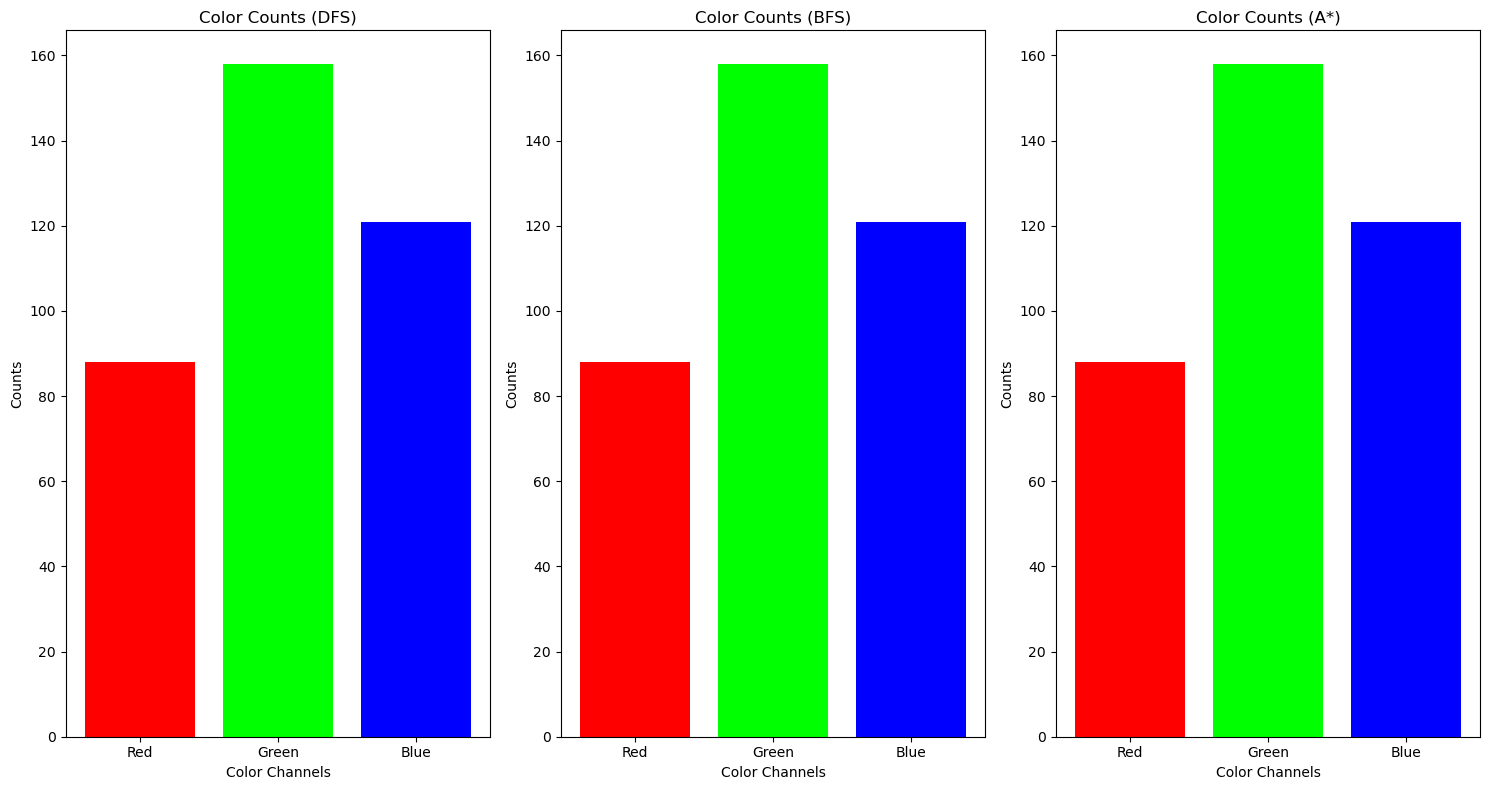

In [16]:
# Set the figure size
plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)  # DFS bar plot
plot_rgb_bar(dfs_red_values, dfs_red_counts, 'DFS Channel')
plt.title('Color Counts (DFS)')

plt.subplot(1, 3, 2)  # BFS bar plot
plot_rgb_bar(bfs_red_values, bfs_red_counts, 'BFS Channel')
plt.title('Color Counts (BFS)')

plt.subplot(1, 3, 3)  # Astar bar plot
plot_rgb_bar(bfs_red_values, bfs_red_counts, 'Astar Channel')
plt.title('Color Counts (A*)')

plt.tight_layout()
plt.show()

# RGB Values Conversion to Hexadecimal Code

In [17]:
# Define the target color for detection (in RGB)
target_color = selected_color

# Convert selected_color from NumPy array to tuple
selected_color_tuple = tuple(selected_color)

# Convert selected_color to a string hexadecimal code
selected_color_hex = webcolors.rgb_to_hex(selected_color_tuple)

# Get the name of the selected color
color_name = hex_to_color_name(selected_color_hex)

# Get the name of the selected color
color_name_DFS = closest_color_DFS(selected_color_tuple)
color_name_BFS = closest_color_BFS(selected_color_tuple)
color_name_Astar = closest_color_Astar(selected_color_tuple)

color_name = color_name_DFS; ("DFS"), color_name_BFS; ("BFS"), color_name_Astar; ("Astar")

print("\n")

print(f"Selected color in hexadecimal code (DFS): {color_name_DFS}")
print("\n")

print(f"Selected color in hexadecimal code (BFS): {color_name_BFS}")
print("\n")

print(f"Selected color in hexadecimal code (A*): {color_name_Astar}")
print("\n")


# Display the original image with detected color regions using DFS
cv2.waitKey(0)
cv2.destroyAllWindows()



Selected color in hexadecimal code (DFS): #3cb371


Selected color in hexadecimal code (BFS): #3cb371


Selected color in hexadecimal code (A*): #3cb371




# Identification of Hexadecimal Code to match Webcolors Database

In [18]:
# Function to convert a hexadecimal color code to its corresponding color name
def hex_to_color_name(hex_code):
    try:
        color_name = webcolors.hex_to_name(hex_code)
        return color_name
    except ValueError:
        # If the hexadecimal code is not found in the color database, return "Unknown"
        return "Unknown"
    
    
color_name_DFS = closest_color_DFS(selected_color_tuple)
color_name_BFS = closest_color_BFS(selected_color_tuple)
color_name_Astar = closest_color_Astar(selected_color_tuple)

color_name = color_name_DFS; ("DFS"), color_name_BFS; ("BFS"), color_name_Astar; ("Astar")

# Random selected hexadecimal color code
color_hex = color_name.format(*selected_color_tuple)

# Get the name of the color
color_name = hex_to_color_name(selected_color_hex)

print("\n")

print(f"The color with hexadecimal code {color_hex} is: {color_name}")

print("\n")



The color with hexadecimal code #3cb371 is: Unknown




# Execution Time of Selected Algorithms

In [19]:
# Function to get the execution time of an algorithm
def get_execution_time(func, *args):
    start_time = time.time()
    func(*args)
    end_time = time.time()
    return end_time - start_time

# Get the execution time for each algorithm
dfs_time = get_execution_time(color_detection_dfs, image.copy(), selected_color)
bfs_time = get_execution_time(color_detection_bfs, image.copy(), selected_color)
astar_time = get_execution_time(heuristic, image.copy(), selected_color)


In [20]:
print("\n")

print("DFS Time:", dfs_time)
print("BFS Time:", bfs_time)
print("A* Time:", astar_time)

print("\n")

DFS Time: 4.7069008350372314
BFS Time: 5.160897493362427
A* Time: 0.0059816837310791016


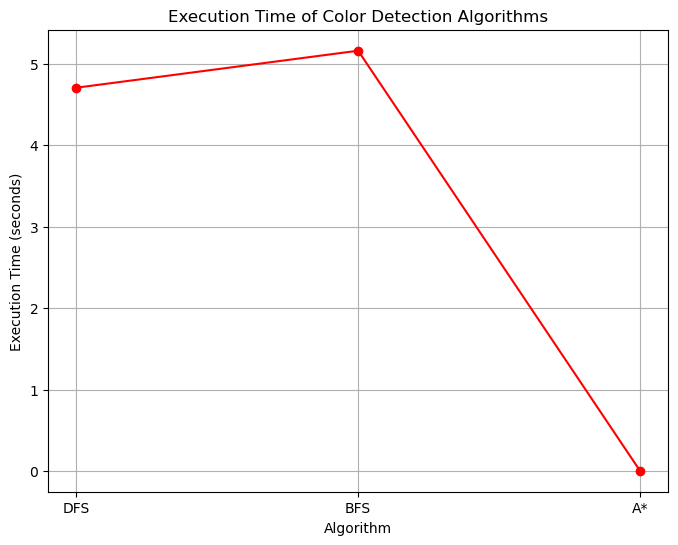

In [21]:
# Plot the execution times in a line graph
algorithms = ['DFS', 'BFS', 'A*']
execution_times = [dfs_time, bfs_time, astar_time]

plt.figure(figsize=(8, 6))

plt.plot(algorithms, execution_times, marker='o', linestyle='-', color='r')

plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of Color Detection Algorithms')
plt.grid(True)
plt.show()

# Path Length Analysis

## DFS

In [22]:
# Color detection using DFS with path length analysis
def color_detection_dfs(image, target_color, tolerance=50):
    height, width, _ = image.shape
    target_color = np.array(target_color)

    # Create a stack for DFS
    stack = []

    # Initialize a mask to keep track of visited pixels
    visited = np.zeros((height, width), dtype=bool)

    # Find the starting pixel for DFS (closest to target_color)
    min_distance = float('inf')
    start_pixel = None

    for y in range(height):
        for x in range(width):
            current_color = np.array(image[y, x])
            distance = np.linalg.norm(current_color - target_color)

            if distance < min_distance:
                min_distance = distance
                start_pixel = (y, x)

    if start_pixel is None:
        return image, 0

    # Define 4-connected neighbors
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    # Perform DFS
    stack.append(start_pixel)
    visited[start_pixel[0], start_pixel[1]] = True
    visited_count = 1  # Initialize the visited pixel count

    while stack:
        current_y, current_x = stack.pop()
        current_color = np.array(image[current_y, current_x])

        # Check if the current pixel is within the tolerance range
        if np.linalg.norm(current_color - target_color) <= tolerance:
            image[current_y, current_x] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

        # Visit neighbors
        for dy, dx in neighbors:
            y, x = current_y + dy, current_x + dx

            if 0 <= y < height and 0 <= x < width and not visited[y, x]:
                stack.append((y, x))
                visited[y, x] = True
                visited_count += 1  # Increment the visited pixel count

    return image, visited_count

## BFS

In [23]:
# Color detection using BFS with path length analysis
def color_detection_bfs(image, target_color, tolerance=50):
    height, width, _ = image.shape
    target_color = np.array(target_color)

    # Create a queue for BFS
    queue = deque()

    # Initialize a mask to keep track of visited pixels
    visited = np.zeros((height, width), dtype=bool)

    # Find the starting pixel for BFS (closest to target_color)
    min_distance = float('inf')
    start_pixel = None

    for y in range(height):
        for x in range(width):
            current_color = np.array(image[y, x])
            distance = np.linalg.norm(current_color - target_color)

            if distance < min_distance:
                min_distance = distance
                start_pixel = (y, x)

    if start_pixel is None:
        return image, 0

    # Define 4-connected neighbors
    neighbors = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    # Perform BFS
    queue.append(start_pixel)
    visited[start_pixel[0], start_pixel[1]] = True
    visited_count = 1  # Initialize the visited pixel count

    while queue:
        current_y, current_x = queue.popleft()
        current_color = np.array(image[current_y, current_x])

        # Check if the current pixel is within the tolerance range
        if np.linalg.norm(current_color - target_color) <= tolerance:
            image[current_y, current_x] = [random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)]

        # Visit neighbors
        for dy, dx in neighbors:
            y, x = current_y + dy, current_x + dx

            if 0 <= y < height and 0 <= x < width and not visited[y, x]:
                queue.append((y, x))
                visited[y, x] = True
                visited_count += 1  # Increment the visited pixel count

    return image, visited_count


# Execution Time and Path Length Analysis

In [24]:
# Function to get the execution time and visited pixel count of an algorithm
def get_execution_time_and_path_length(func, *args):
    start_time = time.time()
    result_image, visited_count, = func(*args)
    end_time = time.time()
    return end_time - start_time, visited_count

In [25]:
# Get the execution time and visited pixel count for each algorithm
dfs_time_pa, dfs_visited_count = get_execution_time_and_path_length(color_detection_dfs, image.copy(), selected_color)
bfs_time_pa, bfs_visited_count = get_execution_time_and_path_length(color_detection_bfs, image.copy(), selected_color)

In [26]:
# Print the visited pixel count for each algorithm
print("DFS Visited Pixels:", dfs_visited_count)
print("BFS Visited Pixels:", bfs_visited_count)

DFS Visited Pixels: 441000
BFS Visited Pixels: 441000


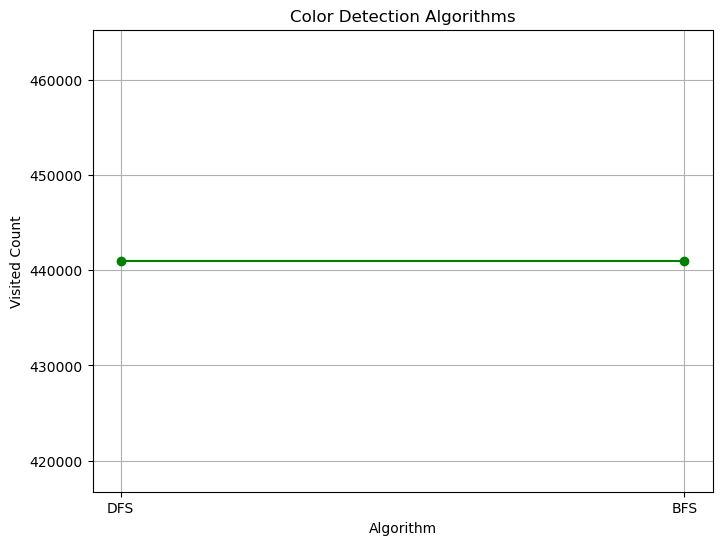

In [31]:
# Plot the execution path length in a line graph
algorithms_pa = ['DFS', 'BFS']
execution_pa = [dfs_visited_count, bfs_visited_count]

plt.figure(figsize=(8, 6))

plt.plot(algorithms_pa, execution_pa, marker='o', linestyle='-', color='g')

plt.xlabel('Algorithm')
plt.ylabel('Visited Count')
plt.title('Color Detection Algorithms')
plt.grid(True)
plt.show()

In [32]:
print("\n")

print("DFS Time:", dfs_time_pa)
print("BFS Time:", bfs_time_pa)

print("\n")

DFS Time: 4.937841176986694
BFS Time: 4.600724935531616


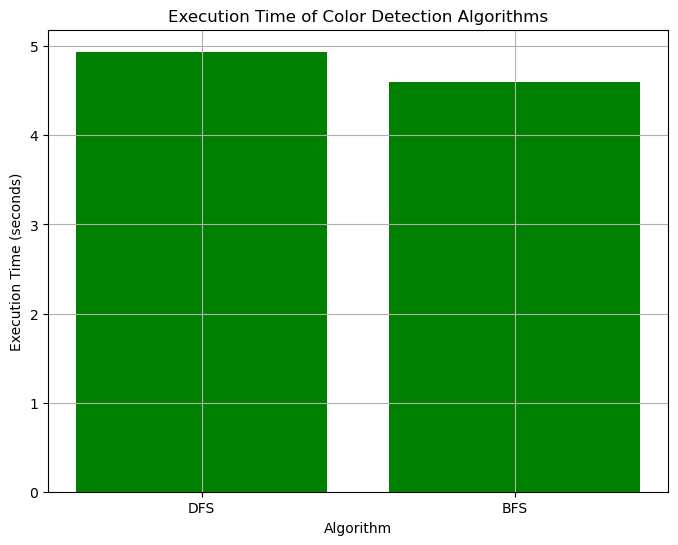

In [33]:
# Plot the execution path length in a line graph
algorithms_pa1 = ['DFS', 'BFS']
execution_times_pa1 = [dfs_time_pa, bfs_time_pa]

plt.figure(figsize=(8, 6))

plt.bar(algorithms_pa1, execution_times_pa1, color='g')

plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of Color Detection Algorithms')
plt.grid(True)
plt.show()

# Comparison of Algorithms

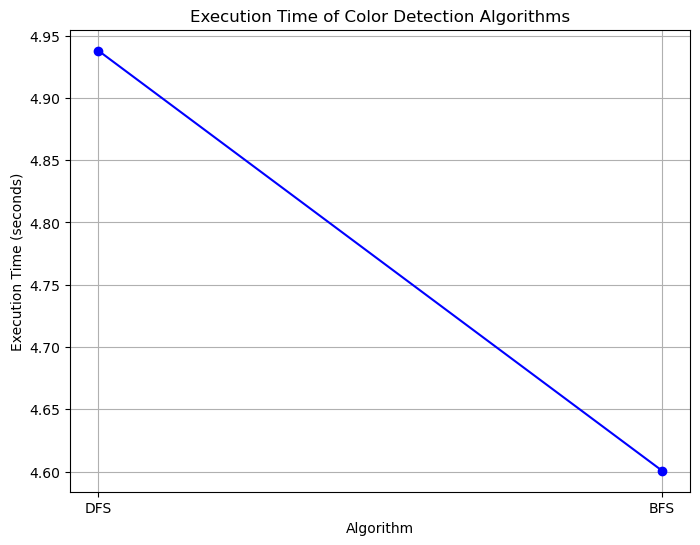

In [34]:
# Plot the execution times in a line graph
algorithms_pa2 = ['DFS', 'BFS']
execution_times_pa2 = [dfs_time_pa, bfs_time_pa]

plt.figure(figsize=(8, 6))

plt.plot(algorithms_pa2, execution_times_pa2, marker='o', linestyle='-', color='b')

plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of Color Detection Algorithms')
plt.grid(True)
plt.show()

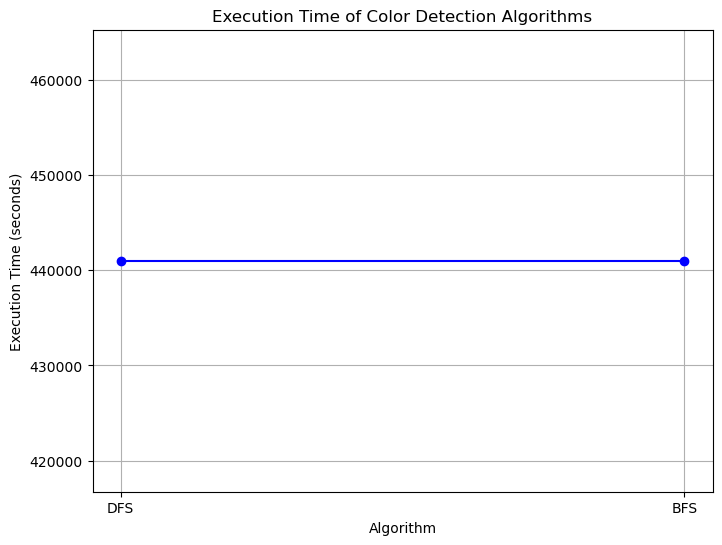

In [35]:
# Plot the execution of path length in a line graph
algorithms_pa3 = ['DFS', 'BFS']
execution_pa3 = [dfs_visited_count, bfs_visited_count]

plt.figure(figsize=(8, 6))

plt.plot(algorithms_pa3, execution_pa3, marker='o', linestyle='-', color='b')

plt.xlabel('Algorithm')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time of Color Detection Algorithms')
plt.grid(True)
plt.show()